### Automated Machine Learning Assignment

### Mortgage Default Risk & Fraud Detection

### Author: Chloe Du (jd3631)

#### Objective

1. data wrangling

2. use the H2O random forest to pre-select variables. This is a good way to limit the number of variables.

3. use random forest on sklearn to conduct modelling

4. apply the SHAP Values to the mortgage probability of default modeling data set (with variables/features).  

5. Please provide the following plots and Interpretation:
  -  The summary_plot
  - The dependence_plot
  - The force_plot for 4 individual observations

#### Part 1: Review the data

In [2]:
#import necessary libraries
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
np.random.seed(0)

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split

There are 80,000 distinct mortgage loan applicants and there are 89 different features.

There are many missing data in the whole dataset. We will deal with these missing values later.

The most common operation used when applying for loan is h5, and the most comman mobile brand used is web.

The target value is loan_default. This indicates if a client will default mortage loan in the future. As the value 0 for default payment means not default and value 1 means default, the mean of 0.1936 means that there are 19.36% of mortgage loan contracts that will default (will verify this in the next sections of this analysis).

We will explore in more detail the data in the following section.

#### Acquire data

In [3]:
# Now to import and put the dataset 
df = pd.read_csv("/Users/jiayangdu/Desktop/Columbia University /APAN 5420/XYZloan_default_selected_vars.csv")
# preview the data
df.head()

,Unnamed: 0,Unnamed: 0.1,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
0,0,1,1,1,31,2,1,12,2017/7/6 10:21,ios,...,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7
1,1,2,2,0,27,1,1,12,2017/4/6 12:51,h5,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB
2,2,3,3,0,33,1,4,12,2017/7/1 14:11,h5,...,3.0,2.0,33.0,0.0,33.0,0.0,143.0,110.0,8.0,WEB
3,3,4,4,0,34,2,4,12,2017/7/7 10:10,android,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,OPPO
4,4,5,5,0,47,2,1,12,2017/7/6 14:37,h5,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB


In [4]:
df.shape

(80000, 89)

In [5]:
##adjust the varibles, drop meaningless variables
df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)

In [6]:
#id has no meaning of value, so we convert it to categorical variables
df['id'] = df['id'].apply(lambda x:str(x))
#AP005 represents the datetime, so we need to convert it to datetime type
df['AP005'] = pd.to_datetime(df['AP005'])

df.info()
#there are some missing values 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 87 columns):
id              80000 non-null object
loan_default    80000 non-null int64
AP001           80000 non-null int64
AP002           80000 non-null int64
AP003           80000 non-null int64
AP004           80000 non-null int64
AP005           80000 non-null datetime64[ns]
AP006           80000 non-null object
AP007           80000 non-null int64
AP008           80000 non-null int64
AP009           80000 non-null int64
TD001           80000 non-null int64
TD002           80000 non-null int64
TD005           80000 non-null int64
TD006           80000 non-null int64
TD009           80000 non-null int64
TD010           80000 non-null int64
TD013           80000 non-null int64
TD014           80000 non-null int64
TD015           80000 non-null int64
TD022           60402 non-null float64
TD023           72337 non-null float64
TD024           76306 non-null float64
TD025           77450 n

In [7]:
#replace -1,-99,-98,-999 to na, since these two strange values may be systematic default value
df.replace(-99.0,' ',inplace=True)
df.replace(-99,' ',inplace=True)
df.replace(-98.0,' ',inplace=True)
df.replace(-98,' ',inplace=True)
df.replace(-999,' ',inplace=True)
df.replace(-99.0,' ',inplace=True)
df.replace(-1,' ',inplace=True)
#replace all empty string to nan
df.replace(r'^\s+$', np.nan, regex=True, inplace = True)

In [8]:
df.head() #missing values have been successfully replaced

,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
0,1,1,31,2,1,12,2017-07-06 10:21:00,ios,3,3,...,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7
1,2,0,27,1,1,12,2017-04-06 12:51:00,h5,5,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WEB
2,3,0,33,1,4,12,2017-07-01 14:11:00,h5,4,2,...,3.0,2.0,33.0,0.0,33.0,0.0,143.0,110.0,8.0,WEB
3,4,0,34,2,4,12,2017-07-07 10:10:00,android,5,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,OPPO
4,5,0,47,2,1,12,2017-07-06 14:37:00,h5,4,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WEB


In [9]:
#missing values
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
TD048,79999,0.999988
TD055,79999,0.999988
TD062,79999,0.999988
TD044,79997,0.999962
TD051,79995,0.999938
TD061,79990,0.999875
TD054,79988,0.999850
PA030,69801,0.872513
PA023,57919,0.723988
PA031,57919,0.723988


In [10]:
#from the above dataframe, we can see that there are some variables missing almost 100% values
#therefore, i will drop those variables which lose up to 50% values
df.drop(['TD055','TD062','TD048','TD044','TD051','TD061','TD054','PA030','PA023','PA031','PA029','PA022','PA028'],axis=1,inplace=True)
# for other columns containing missing values, we do not need to deal with them
# since in the following steps, we will bin some variables and missing values will be regarded as their own categories
# the tree-based algorithms will capture the information from nah values

In [11]:
#get statistics info about numerical variables
df.describe()

,loan_default,AP001,AP002,AP003,AP004,AP007,AP008,AP009,TD001,TD002,...,CD160,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.00000,80000.000000,80000.000000,80000.000000,80000.000000,...,76312.000000,76312.000000,76312.000000,76312.000000,76312.000000,76312.000000,76312.000000,76312.000000,76312.000000,77207.000000
mean,0.193600,31.706913,1.321813,2.014925,11.235413,3.30130,3.117200,0.727925,1.986962,0.706213,...,11.501677,19.180352,16.573750,952.775121,850.212037,1812.070212,1610.332071,2626.427993,2330.516878,5.976272
std,0.395121,7.075070,0.467174,1.196806,2.212313,1.33655,1.306335,0.445031,1.807445,0.918347,...,17.641851,30.743372,24.496918,1392.729146,1256.936168,2463.242747,2191.780118,3433.330482,3029.857757,3.641814
min,0.000000,20.000000,1.000000,1.000000,3.000000,1.00000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,27.000000,1.000000,1.000000,12.000000,2.00000,2.000000,0.000000,1.000000,0.000000,...,3.000000,6.000000,5.000000,123.000000,76.000000,382.000000,294.000000,649.000000,512.000000,3.000000
50%,0.000000,30.000000,1.000000,1.000000,12.000000,3.00000,3.000000,1.000000,2.000000,0.000000,...,7.000000,13.000000,11.000000,518.000000,437.000000,1098.000000,940.000000,1658.000000,1423.000000,5.000000
75%,0.000000,35.000000,2.000000,3.000000,12.000000,5.00000,4.000000,1.000000,3.000000,1.000000,...,14.000000,24.000000,21.000000,1258.000000,1123.000000,2369.000000,2107.000000,3417.000000,3037.000000,8.000000
max,1.000000,56.000000,2.000000,6.000000,12.000000,5.00000,5.000000,1.000000,20.000000,11.000000,...,1061.000000,2792.000000,1579.000000,48585.000000,29664.000000,88364.000000,54651.000000,125352.000000,87312.000000,47.000000


In [12]:
#since after replacing, some numerical categories will become categorical
#so we should convert the data types
df_cat = df.describe(include=['O']).drop(['id','MB007','AP006'],axis=1)
num_columns = df_cat.columns
for col in num_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
#Take a quick look at some basic categorical data
df.describe(include=['O'])
#we can see there is no duplicate applicants 
#h5 is the most common operation system 
#web is the most common operation device

,id,AP006,MB007
count,80000,80000,80000
unique,80000,4,112
top,38301,h5,WEB
freq,1,44246,43850


##### datetime variable

In [13]:
#we cannot employ any DateTime field of the yymmdd:hhmmss format in any tree-based methods. 
# derive year, month, day, weekday, etc. from this field.
df = df.assign(hour=df.AP005.dt.hour,
               day=df.AP005.dt.day,
               month=df.AP005.dt.month,
               year=df.AP005.dt.year)

In [14]:
df['DayofWeek']=df['AP005'].apply(lambda x:x.dayofweek)

In [15]:
#drop unwanted columns
df.drop('AP005',axis=1,inplace=True)

#### Part 2: Target Variable

 Note: our target variable is "loan_default", so we have a logistic problem (0 or 1)

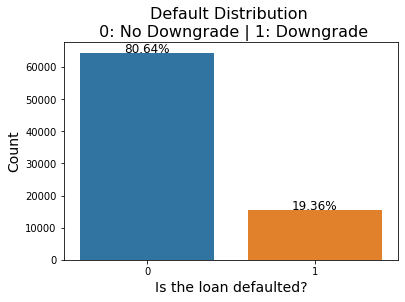

In [16]:
#Visulization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plot_tr = sns.countplot(x='loan_default', data=df)
plot_tr.set_title("Default Distribution \n 0: No Downgrade | 1: Downgrade", fontsize=16)
plot_tr.set_xlabel("Is the loan defaulted?", fontsize=14)
plot_tr.set_ylabel('Count', fontsize=14)
total = len(df)
for p in plot_tr.patches:
    height = p.get_height()
    plot_tr.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 

A 20% target incidence considering the amount of data in the dataset could work, however the proportion is still very small and I consider it to be imbalanced. 

#### Outliers flooring or capping

calculate 99% and 1% percentile as cap and floor for each column, the if value >= 99% percentile then redefine the value as the value of 99% percentile; similarly if value <= 1% percentile then redefine value as the value of 1% percentile

In [17]:
###find out those numerical variables
###make it easier for the following steps (binning continuous variables)
numerical_columns = ['AP001','TD001','TD002','TD005','TD006','TD009','TD010','TD013','TD014',
                     'TD015','TD022','TD023','TD024','TD025','TD026','TD027','TD028','TD029',
                     'CR004','CR005','CR012','CR015','CR017','CR018','CR019','CD008','CD018',
                     'CD071','CD072','CD088','CD100','CD101','CD106','CD107','CD108','CD113',
                     'CD114','CD115','CD117','CD118','CD120','CD121','CD123','CD130','CD131',
                     'CD132','CD133','CD135','CD136','CD137','CD152','CD153','CD160','CD162','CD164',
                     'CD166','CD167','CD169','CD170','CD172','CD173','MB005']
ordinal_columns = ['AP002','AP003','AP004','AP007','AP008','AP009','AP006','MB007','year','month','day','hour','DayofWeek']

In [19]:
for col in numerical_columns:
    percentiles = df[col].quantile([0.01,0.99]).values
    df[col][df[col] <= percentiles[0]] = percentiles[0]
    df[col][df[col] >= percentiles[1]] = percentiles[1]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stabl

#### missing values

We need to impute missing values up front if there are many.

Then use fillna() to impute the missing values with the median values(not use mean since mean is influenced by outliers) for numerical values, while impute with mode values for categorical/ordinal columns. Use the for-loop function to impute missing values for those columns.

In [20]:
def null_cell(df):
    missing_values = df.isnull().sum()
    missing_values_per = df.isnull().sum() / df.isnull().count()
    null_values = pd.concat([missing_values, missing_values_per],axis=1, keys = ['the_null','the_null_perc'])
    null_values = null_values.sort_values('the_null',ascending=False)
    return null_values[null_values['the_null']>0]

In [21]:
#for numerical columns, fill in the median values
fill_list = (null_cell(df[numerical_columns])).index
print(fill_list)
for col in fill_list:
    df.loc[:,col].fillna(df.loc[:,col].median(),inplace=True)

Index(['TD022', 'TD023', 'TD024', 'CD123', 'CD121', 'CD008', 'CD018', 'CD071',
       'CD072', 'CD088', 'CD101', 'CD131', 'CD100', 'CD120', 'CD106', 'CD107',
       'CD108', 'CD113', 'CD114', 'CD115', 'CD130', 'CD133', 'CD132', 'CD164',
       'CD173', 'CD172', 'CD170', 'CD169', 'CD167', 'CD166', 'CD162', 'CD118',
       'CD160', 'CD153', 'CD152', 'CD137', 'CD136', 'CD135', 'CD117', 'MB005',
       'TD025', 'TD026', 'TD027', 'TD028', 'TD029'],
      dtype='object')


In [22]:
#for ordinal/cat columns, fill in mode 
fill_list_2 = (null_cell(df[ordinal_columns])).index
print(fill_list_2)
for col in fill_list_2:
    df.loc[:,col].fillna(df.loc[:,col].mode(),inplace=True)

Index([], dtype='object')


In [24]:
#missing values
sum(df.isnull().sum()) #we've gotten rid of all our NAs

0

#### Categorical variables

"Letting GLM handle categorical columns is better, as it can take advantage of the categorical column for better performance and memory utilization. We strongly recommend avoiding one-hot encoding categorical columns with many levels into many binary columns, as this is very inefficient. This is especially true for Python users who are used to expanding their categorical variables manually for other frameworks."

h2o will automatically expands categoricals into 1-hot encoded binary vectors

reference:https://www.h2o.ai/wp-content/uploads/2018/01/GLM-BOOKLET.pdf

In [25]:
#Create list with categorical features' names.
#AP002gender, AP003 education level,  Ap004 loan_term (3,6,12), AP007 level_apply_city, AP008 FLAG_IP_CITY_NOT_APPL_CITY, 
#ordinal_columns = ['AP002','AP003','AP004','AP007','AP008','AP009','AP006','MB007','year','month','day','hour','DayofWeek']
#Assign appropriate data type to categorical variables.
nonum_feats = df[ordinal_columns].astype('category')
nonum_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 13 columns):
AP002        80000 non-null category
AP003        80000 non-null category
AP004        80000 non-null category
AP007        80000 non-null category
AP008        80000 non-null category
AP009        80000 non-null category
AP006        80000 non-null category
MB007        80000 non-null category
year         80000 non-null category
month        80000 non-null category
day          80000 non-null category
hour         80000 non-null category
DayofWeek    80000 non-null category
dtypes: category(13)
memory usage: 1.0 MB


In [26]:
#One-hot-code categorical variables and dropping the reference value.
ohc_feats = pd.get_dummies(nonum_feats,drop_first=True)
ohc_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Columns: 194 entries, AP002_2 to DayofWeek_6
dtypes: uint8(194)
memory usage: 14.8 MB


In [31]:
df_1 = pd.concat([df[numerical_columns], ohc_feats],axis=1) #df_1 do not contain target variable

In [32]:
#add label back to dataset
df_1['loan_default'] = df['loan_default'].tolist()

#### Predictor and target

In [33]:
var = pd.DataFrame(df_1.dtypes).reset_index()
var.columns = ['varname','dtype'] 
var['source'] = var['varname'].str[:2]
var.head(10)

,varname,dtype,source
0,AP001,int64,AP
1,TD001,int64,TD
2,TD002,int64,TD
3,TD005,int64,TD
4,TD006,int64,TD
5,TD009,int64,TD
6,TD010,int64,TD
7,TD013,int64,TD
8,TD014,int64,TD
9,TD015,int64,TD


In [34]:
var['source'].value_counts()

MB    112
CD     36
da     30
ho     23
AP     21
TD     17
CR      7
Da      6
mo      4
lo      1
Name: source, dtype: int64

In [35]:
# "AP004" is a bad data field and should be removed.
MB_list = list(var[var['source']=='MB']['varname'])
AP_list = list(var[(var['source']=='AP') & (var['varname']!='AP004')]['varname'])
TD_list = list(var[var['source']=='TD']['varname'])
CR_list = list(var[var['source']=='CR']['varname'])
PA_list = list(var[var['source']=='PA']['varname'])
CD_list = list(var[var['source']=='CD']['varname'])
# other remaining variables to get a dummy list
other_list = list(set(list(df_1.columns)).difference(set(MB_list+AP_list+TD_list+CR_list+PA_list+CD_list)))
other_list.remove('loan_default')

In [36]:
predictors = MB_list + TD_list + AP_list + CD_list + CR_list + PA_list + other_list
target='loan_default'

#### Use H2O random forest to pre-select variables

In [37]:
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,4 mins 05 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.7
H2O_cluster_version_age:,"21 days, 4 hours and 20 minutes"
H2O_cluster_name:,H2O_from_python_jiayangdu_wi5evt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.757 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [40]:
X_train, X_test = train_test_split(df_1, test_size = 0.3)

In [41]:
#try small sample dataset to run model first
from h2o.frame import H2OFrame
train_smpl = X_train.sample(frac=0.1, random_state=1)
test_smpl = X_test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [42]:
# Define model
h2o_rf = H2ORandomForestEstimator(ntrees=900, max_depth=7, nfolds=10)

# Train model
h2o_rf.train(predictors,target,training_frame=train_hex)

/opt/anaconda3/lib/python3.7/site-packages/h2o/estimators/estimator_base.py:200: RuntimeWarning: Dropping bad and constant columns: [MB007_ANDROID, MB007_OWWO, MB007_BIRD, MB007_X6, MB007_SUGAR, MB007_NOKIA, MB007_EYU, MB007_YU-FLY, MB007_YEPEN, MB007_MC-X7MINI, MB007_MYTEL, MB007_AND, MB007_ZUOKU, MB007_PROTRULY, MB007_REDGOO, MB007_DOOV, MB007_MEDIATEK, MB007_XIAOLAJIAO, MB007_RAMOS, MB007_DOOVL5PRO, MB007_YTONE_L985, MB007_HRT, MB007_MANN, MB007_APPLE, MB007_CHINAMOBILE, MB007_CMCC, TD029, MB007_OUKI, TD028, TD027, MB007_VEGA, TD026, TD025, MB007_ASUS, MB007_PHILIPS, MB007_BOWAY, MB007_VERIZON, MB007_4G, MB007_HMI, MB007_VOTO, MB007_VETAS, MB007_BIFER, CR012, MB007_FOPAD, MB007_MLLED, MB007_KOPO, MB007_ALPS, MB007_KONKA, MB007_VOLTE, MB007_DAQ, MB007_SKYHON, MB007_TCT, MB007_GOOGLE, MB007_MILAI, MB007_SM-W2016, MB007_ROAM_CAT, MB007_SGMSGMS, MB007_CONGMETAL, MB007_MONEYMAKINGMACHINE, AP003_6, MB007_KINGSUN, MB007_TCL, MB007_IVVI, MB007_IPAD6, MB007_KDDI, MB007_UOOGOU, MB007_IPAD5, M

drf Model Build progress: |███████████████████████████████████████████████| 100%


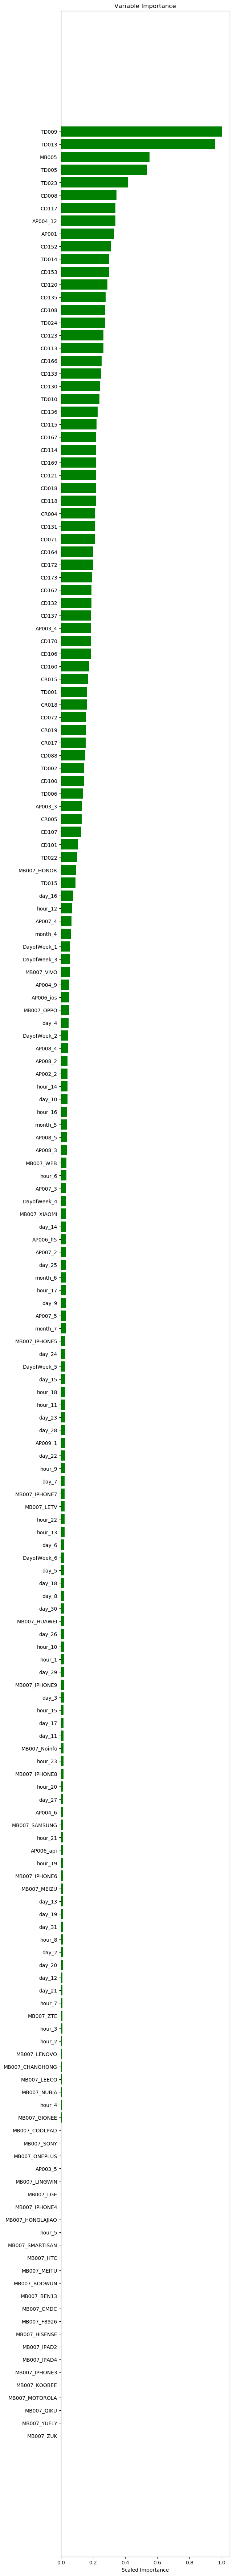

In [43]:
def VarImp(model_name):
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()
    
#check the variable importance 
VarImp(h2o_rf)

In [46]:
#extract the top 30 most important variables
predictors = ['TD009','TD013','MB005','TD005','TD023','CD008','CD117','AP004_12','AP001','CD152',
             'TD014','CD153','CD120','CD135','CD108','TD024','CD123','CD113','CD166','CD133',
             'CD130','TD010','CD136','CD115','CD167','CD114','CD169','CD121','CD018','CD118']

#### Explain Your Model with the SHAP Values

In [47]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

In [52]:
X = df_1[predictors]
y = df_1[target]
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3)

In [58]:
X_train_smpl = X_train.sample(frac=0.1, random_state=1)
X_test_smpl = X_test.sample(frac=0.1, random_state=1)
Y_train_smpl = Y_train.sample(frac=0.1, random_state=1)
Y_test_smpl = Y_test.sample(frac=0.1, random_state=1)

In [60]:
X_test_smpl.shape

(2400, 30)

In [61]:
X_test_smpl.mean()

TD009           5.350000
TD013           6.691667
MB005           5.995417
TD005           3.552500
TD023           7.188750
CD008       13606.038250
CD117          54.037600
AP004_12        0.889167
AP001          31.833750
CD152       13625.196754
TD014           2.571667
CD153       13662.237992
CD120          91.130833
CD135         135.853750
CD108           5.363992
TD024           5.445833
CD123         121.552917
CD113           3.522917
CD166         902.732058
CD133         113.777083
CD130          93.452083
TD010           2.021667
CD136         127.274167
CD115          74.540833
CD167         798.776033
CD114           5.343750
CD169        1754.017892
CD121         164.144583
CD018         440.412500
CD118         123.689583
dtype: float64

#### Random Forest on sklearn

[0.01865548 0.27885687 0.03113952 0.0319547  0.00490607 0.02113466
 0.01265079 0.12485301 0.0304593  0.01782176 0.0199608  0.02027792
 0.02352185 0.01082123 0.02123746 0.01048056 0.05338944 0.0318495
 0.01700231 0.01556625 0.01217737 0.01815188 0.00937061 0.01721256
 0.01647609 0.04650395 0.03469501 0.02314865 0.01634669 0.00937771]


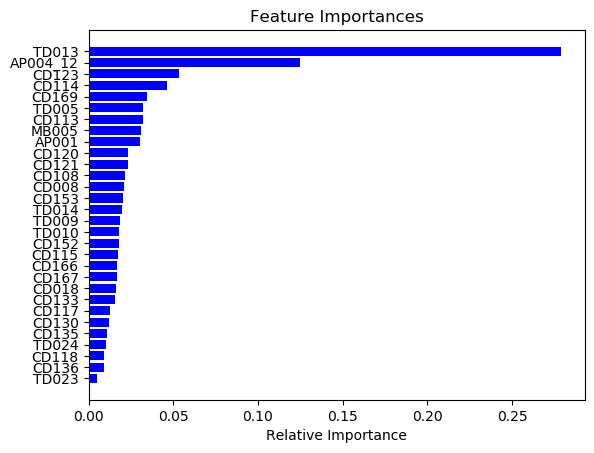

In [55]:
rf = RandomForestRegressor(max_depth=7, random_state=0, n_estimators=10)
rf.fit(X_train, Y_train)  
print(rf.feature_importances_)

importances = rf.feature_importances_
indices = np.argsort(importances)

features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [64]:
import shap
shap_values = shap.TreeExplainer(rf).shap_values(X_train_smpl)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


From the figure below, we can see that TD013 TD_CNT_QUERY_LAST_6MON_P2P contributes the most to the model, followed by CD123 CNT_DISTINCT_OUTBOUND_CALLS_LAST_3MON and whether the loan term is 12-month, but from the summary plot, we can not tell if it is positively or negatively correlated to the target variable 

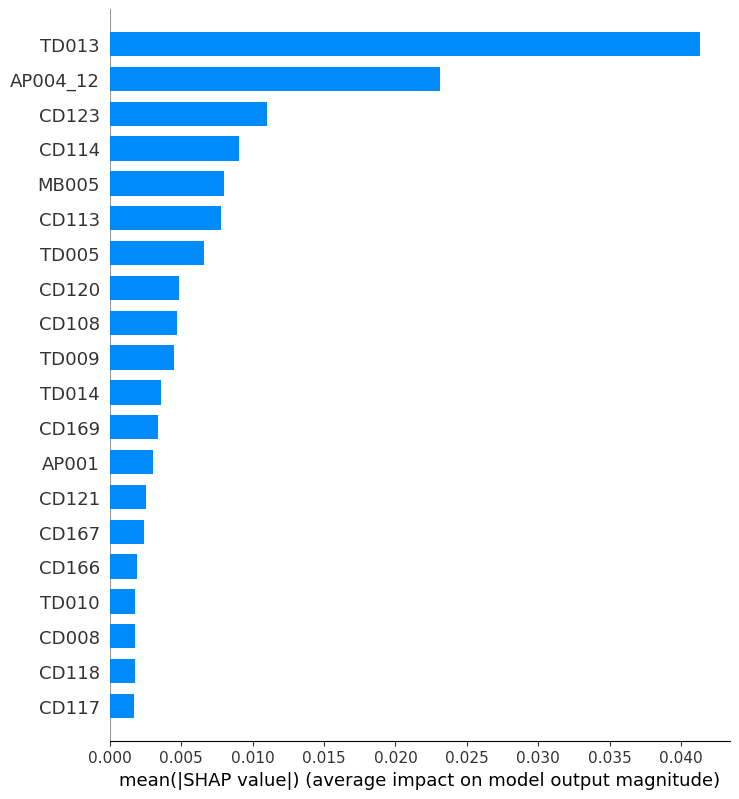

In [69]:
shap.summary_plot(shap_values, X_train_smpl, plot_type="bar")

The graph below plots the SHAP values of every feature for every sample. It shorts features by the total of absolute SHAP values over all samples. The color represents the feature value (red high, blue low).
 - The vertical location shows the feature importance.
 - The horizontal location shows whether the effect of that value caused a higher or lower prediction.
 - Color shows whether that feature was high or low for that observation

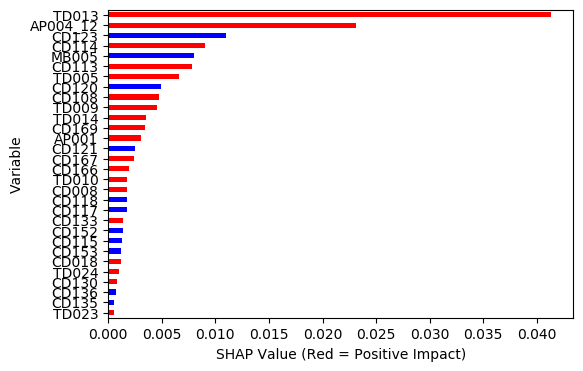

In [70]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(6,4),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,X_train_smpl)  

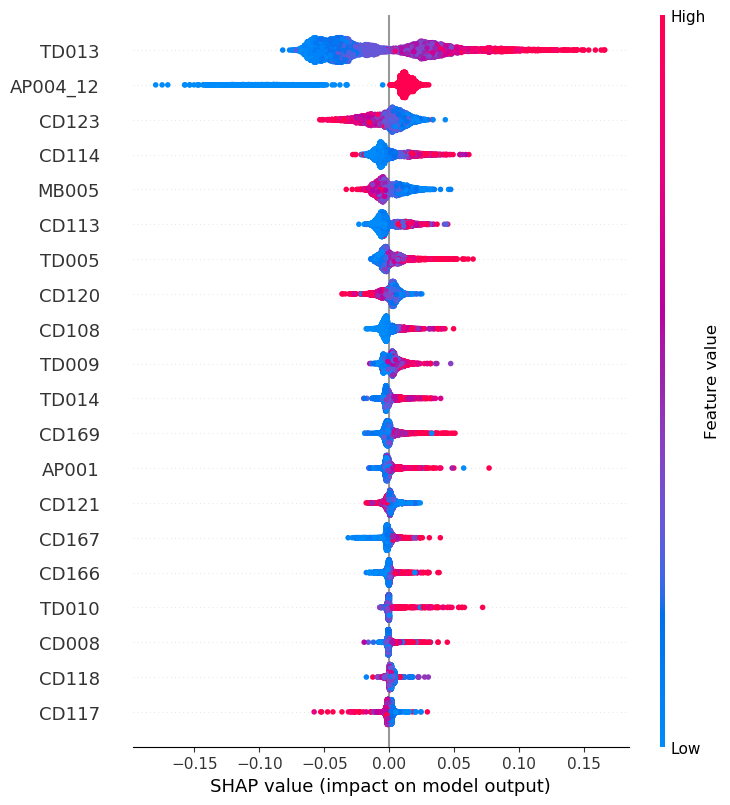

In [71]:
shap.summary_plot(shap_values, X_train_smpl)

We can describe the model. A loan applicant who is most likely to default is associated with the following characteristics:
 - High TD_CNT_QUERY_LAST_6MON_P2P
 - Apllied a loan with loan term of 12 month
 - Low CNT_DISTINCT_OUTBOUND_CALLS_LAST_3MON
 - High CNT_ABNORMAL_HOURS_CALL_DAYS_LAST_3MON
 - Low YR_PHONE_ACTIVE
 - High CNT_ABNORMAL_HOURS_CALL_DAYS_LAST_2MON
 - High TD_CNT_QUERY_LAST_1MON_P2P
 - Low CNT_DISTINCT_OUTBOUND_CALLS_LAST_2MON
 - High CNT_ABNORMAL_HOURS_OUTBOUND_CALLS_LAST_3MON
 - High TD_CNT_QUERY_LAST_3MON_P2P
 - High TD_CNT_QUERY_LAST_6MON_SMALL_LOAN
 - High LEN_SERVICE_CALLS_LAST_2MON
 - High YR_AGE
 - Low CNT_DISTINCT_CALLS_LAST_3MON
 - High LEN_SERVICE_OUTBOUND_CALLS_LAST_1MON
 - High LEN_SERVICE_CALLS_LAST_1MON
 - High TD_CNT_QUERY_LAST_3MON_SMALL_LOAN
 - High LEN_TOTAL_INBOUND_CALLS_LAST_1MON
 - Low CNT_DISTINCT_CALLS_LAST_2MON
 - Low CNT_DISTINCT_OUTBOUND_CALLS_LAST_1MON

#### The dependence_plot

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in predicted probability of default as some factors such as TD_CNT_QUERY_LAST_6MON_P2P/CNT_DISTINCT_OUTBOUND_CALLS_LAST_3MON/CNT_ABNORMAL_HOURS_CALL_DAYS_LAST_3MON/LEN_SERVICE_CALLS_LAST_2MON changes.

A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model.

 - Each dot is a single prediction (row) from the dataset.
 - The x-axis is the value of the feature (from the X matrix).
 - The y-axis is the SHAP value for that feature, which represents how much knowing that feature's value changes the output of the model for that sample's prediction.
 - The color corresponds to a second feature that may have an interaction effect with the feature we are plotting (by default this second feature is chosen automatically). If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring. 

Vertical dispersion at a single value of TD013(TD_CNT_QUERY_LAST_6MON_P2P) represents interaction effects with other features. To help reveal these interactions dependence_plot automatically selects another feature for coloring. In this case coloring by Ap004_12 (whether the loan term is 12-month or not) highlights that the average number of TD_CNT_QUERY_LAST_6MON_P2P has more impact on the probability of loan deafult for loan with loan term of 12 month. It indicates the higher the TD_CNT_QUERY_LAST_6MON_P2P the applicant made, the more likely the applicant to default, and the applicant applied for the loan with loan term of 12 month is more likely to default than applicant who applied for a loan with a non-twelve-month term in this situation. 

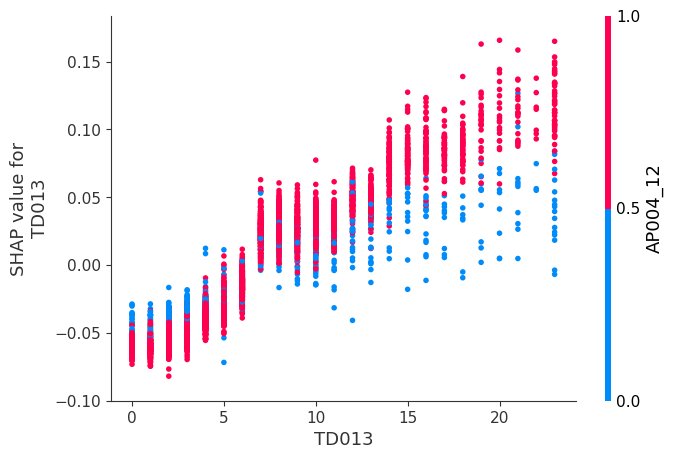

In [73]:
shap.dependence_plot("TD013", shap_values, X_train_smpl)

Vertical dispersion at a single value of CD123(CNT_DISTINCT_OUTBOUND_CALLS_LAST_3MON) represents interaction effects with other features. To help reveal these interactions dependence_plot automatically selects another feature for coloring. In this case coloring by Ap004_12 (whether the loan term is 12-month or not) highlights that the average number of TD_CNT_QUERY_LAST_6MON_P2P has less impact on the probability of loan deafult for loan with loan term of 12 month. It suggests that CD123 is negatively influence the target especially for those loan whose loan term is 12-month.

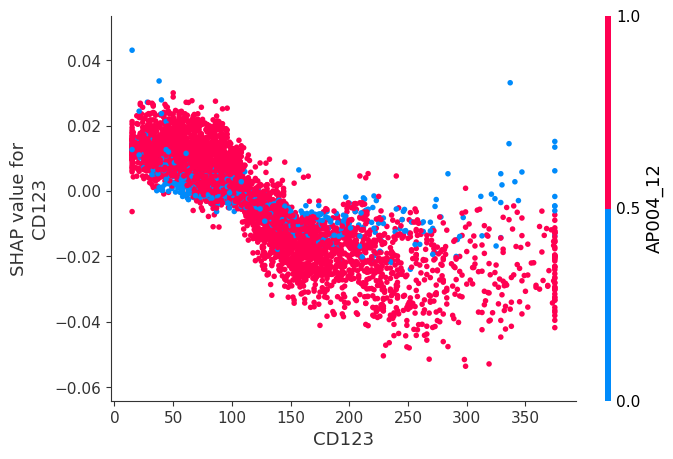

In [74]:
shap.dependence_plot("CD123", shap_values, X_train_smpl)

Vertical dispersion at a single value of CD114(CNT_ABNORMAL_HOURS_CALL_DAYS_LAST_3MON) represents interaction effects with other features. To help reveal these interactions dependence_plot automatically selects another feature for coloring. In this case coloring by TD013 (TD_CNT_QUERY_LAST_6MON_P2P) highlights that the probability of loan default increases significantly between CD114 0 and 20. 20-CD114 with a low level of TD013 are more likely to default than below 20-CD114 with a high level of TD013.

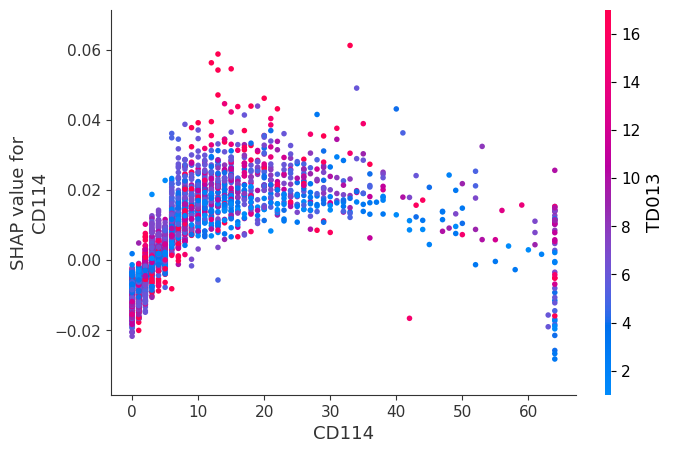

In [76]:
shap.dependence_plot("CD114", shap_values, X_train_smpl)

Vertical dispersion at a single value of CD169(LEN_SERVICE_CALLS_LAST_2MON) represents interaction effects with other features. To help reveal these interactions dependence_plot automatically selects another feature for coloring. In this case coloring by TD013 (TD_CNT_QUERY_LAST_6MON_P2P) highlights that the probability of loan default increases significantly as CD169 increases. High level of CD169 with a low level of TD013 are more likely to default than low level of CD169 with a high level of TD013.

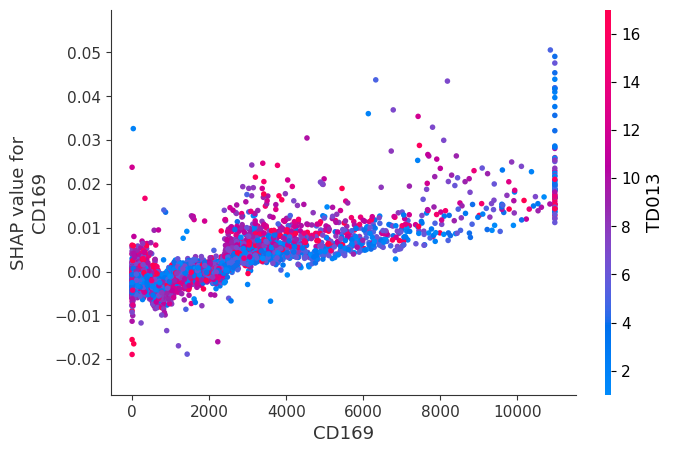

In [79]:
shap.dependence_plot("CD169", shap_values, X_train_smpl)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


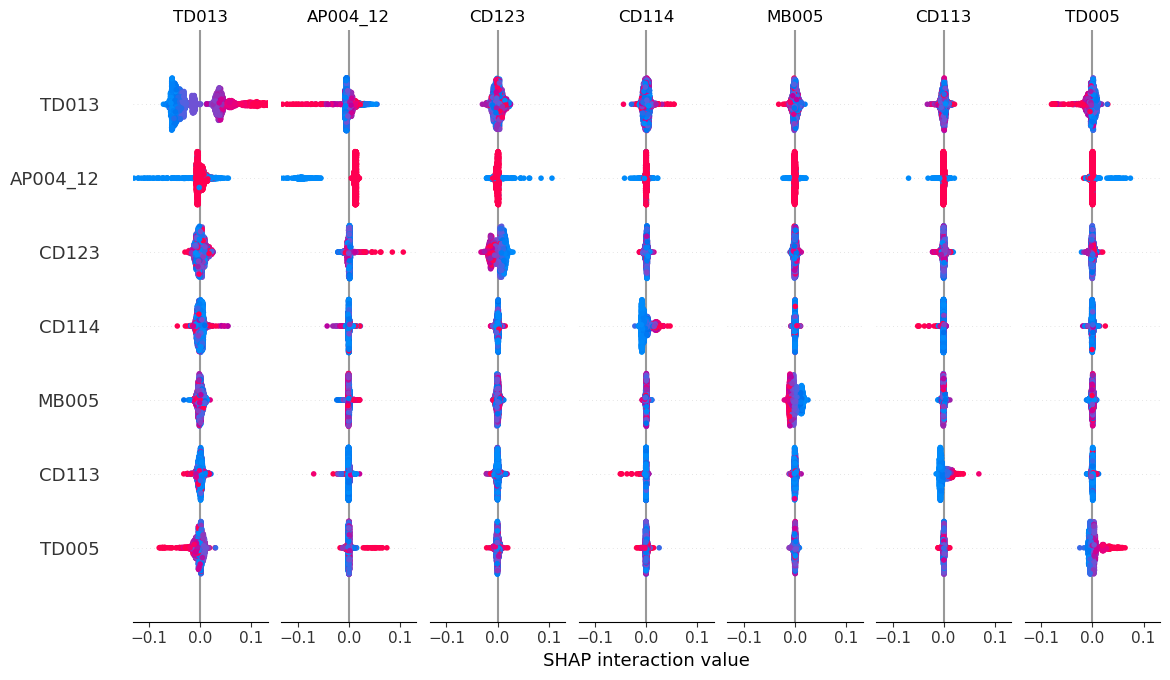

In [80]:
# takes a couple minutes since SHAP interaction values take a factor of 2 * # features
# more time than SHAP values to compute, since this is just an example we only explain
# the first 2,000 people in order to run quicker
shap_interaction_values = shap.TreeExplainer(rf).shap_interaction_values(X_train_smpl.iloc[:2000,:])

shap.summary_plot(shap_interaction_values, X_train_smpl.iloc[:2000,:])

In [82]:
X_output = X_test_smpl.copy()
X_output.loc[:,'predict'] = np.round(rf.predict(X_output),2)

random_picks = np.arange(1,330,50)
S = X_output.iloc[random_picks]
S

,TD009,TD013,MB005,TD005,TD023,CD008,CD117,AP004_12,AP001,CD152,...,TD010,CD136,CD115,CD167,CD114,CD169,CD121,CD018,CD118,predict
789,9,11,7.0,5,9.0,2774.0,31.0,1,24,6745.0,...,5,66.0,39.0,2551.0,49.0,5441.0,138.0,155.0,95.0,0.29
65926,0,2,11.0,0,6.0,16159.0,112.0,1,49,6239.0,...,0,131.0,151.0,0.0,6.0,1938.0,316.0,778.0,240.0,0.09
6130,12,19,13.0,6,9.0,9363.0,63.0,1,37,5229.0,...,4,33.0,89.0,666.0,5.0,1093.0,177.0,538.0,147.0,0.33
34503,0,1,10.0,0,6.0,4536.0,17.0,1,25,740.0,...,0,3.0,22.0,203.0,1.0,203.0,52.0,38.0,37.0,0.10
4003,1,1,4.0,1,3.0,7587.0,32.0,1,28,6514.0,...,2,63.0,35.0,0.0,1.0,1798.0,118.0,167.0,84.0,0.12
17918,1,3,7.0,0,6.0,34039.0,62.0,1,48,58779.0,...,1,227.0,95.0,638.0,7.0,2696.0,173.0,859.0,151.0,0.18
67217,4,10,0.0,2,3.0,939.0,11.0,1,26,2826.0,...,2,11.0,15.0,76.0,2.0,76.0,72.0,37.0,28.0,0.27


In [83]:
shap.initjs()

In [84]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(rf)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [85]:
X_train_smpl.mean()

TD009           5.262143
TD013           6.636250
MB005           5.940714
TD005           3.543036
TD023           7.052679
CD008       13598.176800
CD117          53.238425
AP004_12        0.882679
AP001          31.676071
CD152       13224.972539
TD014           2.523750
CD153       13406.299032
CD120          89.368929
CD135         135.570000
CD108           5.211379
TD024           5.228214
CD123         119.383393
CD113           3.386250
CD166         924.349786
CD133         113.767500
CD130          92.545000
TD010           1.950893
CD136         124.633036
CD115          73.619464
CD167         822.950307
CD114           5.136071
CD169        1766.744946
CD121         162.083214
CD018         435.116250
CD118         121.830357
dtype: float64

In [86]:
Y_test_smpl.mean()

0.18291666666666667

#### The force_plot for 4 individual observations

 - Output value: is the prediction for that observation
 - Base value: The original paper explains that the base value E(y_hat) is "the value that would be predicted if we did not know any features for the current output." In other words, it is the mean prediction, or mean(yhat). 
 - Features: The above explanation shows features that contributes to push the final prediction away from the base value.
 - Red/blue: Those features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.

For the first predicted observation:
    
 - the prediction for this observation is 0.29 (the probability of default)
 - the mean prediction of Y_test is 0.193
 - TD013: has positive impact on the probability of loan default, The TD013 of this applicant is 11 which is higher than the average value 6.636250. So it pushes the prediction to the right. 
 - CD169: is positively related to the probability of loan default. A higher than the average Sulphates (= 5,441 > 1766.744946) pushes the prediction to the right.
 - CD108: has positive impact on the probability of loan default, The CD108 of this applicant is 30 which is higher than the average value 5.211379. So it pushes the prediction to the right. 
 - Similarly,  other factors including TD010,TD014,CD113,APP004_12,CD114 are all positively related to the probability of loan default and their value for this applicant is higher than their respective averages, so they all push the prediction to the right. 
 - MB005: is negatively related to the probability of loan default.A higher than the average Sulphates (= 7 > 5.940714) pushes the prediction to the left.

In [87]:
shap_plot(0)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


For the second predicted applicant:
    
 - the prediction for this observation is 0.09 (the probability of default)
 - the mean prediction of Y_test is 0.193
 - TD013: has positive impact on the probability of loan default, The TD013 of this applicant is 2 which is lower than the average value 6.636250. So it pushes the prediction to the left. 
 - CD113: is positively related to the probability of loan default. A higher than the average Sulphates (= 6 >  3.386250) pushes the prediction to the right.
 - CD123: has negative impact on the probability of loan default, The CD123 of this applicant is 235 which is higher than the average value 119.383393. So it pushes the prediction to the left. 
 - CD120: has negative impact on the probability of loan default, The CD123 of this applicant is 174 which is higher than the average value 89.368929. So it pushes the prediction to the left. 
 - TD005:  is positively related to the quality rating. A lower than the average Sulphates (= 0 < 3.543036) slightly pushes the prediction to the left.

In [88]:
shap_plot(1)

For the third predicted applicant:
    
 - the prediction for this observation is 0.33 (the probability of default)
 - the mean prediction of Y_test is 0.193
 - TD009: has positive impact on the probability of loan default, The TD009 of this applicant is 12 which is higher than the average value 5.262143. So it pushes the prediction to the right. 
 - CD113: is positively related to the probability of loan default. A higher than the average Sulphates (= 4 >  3.386250) pushes the prediction to the right.
 - TD013:  is positively related to the quality rating. A higher than the average Sulphates (= 19 > 6.636250) heavily pushes the prediction to the right.

In [89]:
shap_plot(2)

For the fourth predicted observation:
    
 - the prediction for this observation is 0.10 (the probability of default)
 - the mean prediction of Y_test is 0.193
 - TD013:  is positively related to the quality rating. A lower than the average Sulphates (= 1 < 6.636250) heavily pushes the prediction to the left.
 - MB005: has negative impact on the probability of loan default, The MB005 of this applicant is 10 which is higher than the average value 5.940714. So it pushes the prediction to the left. 
 - TD005: is positively related to the probability of loan default. A lower than the average (= 0 < 3.543036) pushes the prediction to the left.
 - CD108, CD113, TD009, CD114: are all postively related to the target variable. Their values for this observation are all lower than their respective average, so they all push the prediction to the left. 
 - CD120: is negatively related to the target variable, but a lower than the average (=20  < 89.368929) push the predication to the right.
 
Finally the merged force pushes the prediction to the left. 

In [90]:
shap_plot(3)